<a href="https://colab.research.google.com/github/Ankan1998/Semantic-Segmentation/blob/main/Semantic_Segmentation_deeplabV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!nvidia-smi

Mon Oct 12 04:58:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import os
import zipfile
import torch
import torchvision
import matplotlib.pyplot as plt
import tensorboard
import numpy as np
from PIL import Image

### **Kaggle preparation**
##### Aerial dataset of kaggle

In [2]:
#upload kaggle json token
from google.colab import files
uploaded=files.upload()

Saving kaggle.json to kaggle.json


In [4]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 4.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.8-cp36-none-any.whl size=73275 sha256=6132dcbb8b824c6e456264f840a3362abfbe5c53711fa26c6ba1d6fdee854db8
  Stored in directory: /root/.cache/pip/wheels/94/a7/09/68dc83c7c14fdbdf5d3f2b2da5b87e587bfc1e85df69b1130c
Successfully built kaggle
  Found existing installation: kaggle 1.5.8
    Uninstalling kaggle-1.5.8:
      Successfully uninstalled kaggle-1.5.8


In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d bulentsiyah/semantic-drone-dataset -p "/tmp"

100% 3.82G/3.83G [01:18<00:00, 35.2MB/s]
100% 3.83G/3.83G [01:18<00:00, 52.3MB/s]


In [7]:
local_zip='/tmp/semantic-drone-dataset.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall("/content")
zip_ref.close()

### **Checking with one pair of image**

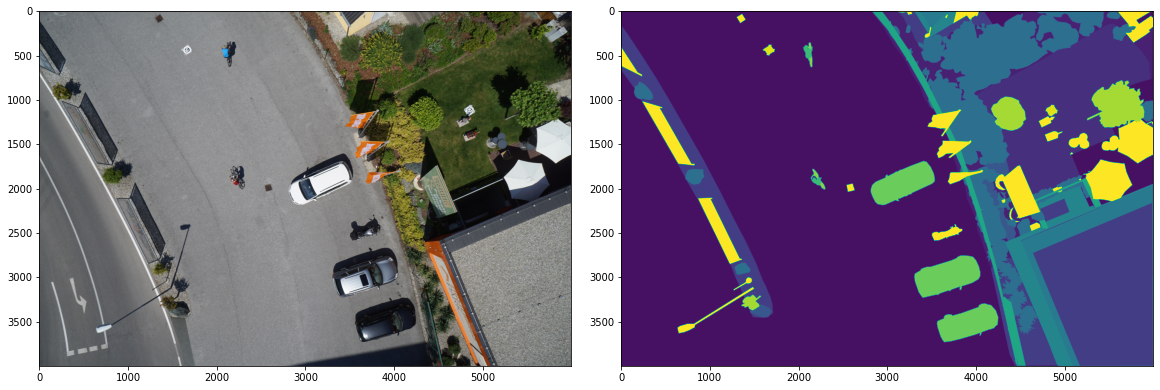

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

original_image = "/content/semantic_drone_dataset/original_images/004.jpg"
label_image_semantic = "/content/semantic_drone_dataset/label_images_semantic/004.png"

fig, axs = plt.subplots(1, 2, figsize=(16, 8), constrained_layout=True)

axs[0].imshow( Image.open(original_image))

axs[1].imshow(Image.open(label_image_semantic))


In [12]:
import cv2
 
img = cv2.imread('/content/semantic_drone_dataset/original_images/008.jpg', cv2.IMREAD_UNCHANGED)
mask = cv2.imread('/content/semantic_drone_dataset/label_images_semantic/008.png')
dim = (256, 256)
# resize image
resized_mask = cv2.resize(mask, dim)
resized_img = cv2.resize(img, dim)

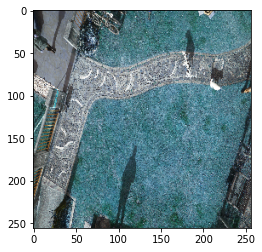

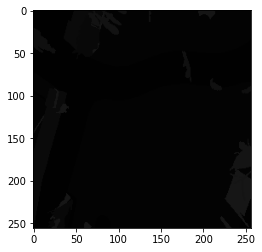

In [13]:
plt.imshow(resized_img)
plt.show()
plt.imshow(resized_mask)
plt.show()

## **Constructing Custom dataset**

In [8]:
from torch.utils.data import Dataset, DataLoader, sampler

In [15]:
"""
def classes(mask_dir):
  mask_file=os.listdir(mask_dir)
  mask_class=[]
  for i in range(len(mask_file)):
    mask_name=os.path.join(mask_dir,mask_file[i])
    mask = Image.open(mask_name)
    mask_class.append(max(list(np.unique(np.array(mask)))))
    print(mask_class)
  return max(mask_class)

  
NUM_OF_CLASSES=classes("/content/semantic_drone_dataset/label_images_semantic")
"""

'\ndef classes(mask_dir):\n  mask_file=os.listdir(mask_dir)\n  mask_class=[]\n  for i in range(len(mask_file)):\n    mask_name=os.path.join(mask_dir,mask_file[i])\n    mask = Image.open(mask_name)\n    mask_class.append(max(list(np.unique(np.array(mask)))))\n    print(mask_class)\n  return max(mask_class)\n\n  \nNUM_OF_CLASSES=classes("/content/semantic_drone_dataset/label_images_semantic")\n'

In [9]:
# Find number of classes category
NUM_OF_CLASSES=26

In [10]:
# Creating own dataset
class Satellite_Dataset(Dataset):
    def __init__(self, img_dir,mask_dir,transform=None):
      self.img_dir=img_dir
      self.mask_dir=mask_dir
      self.img_file_list=sorted(os.listdir(img_dir))
      self.mask_file_list=sorted(os.listdir(mask_dir))
      self.transform = transform
        

    def __len__(self):
      return len(self.img_file_list)

    def __getitem__(self, index):
      img_name=os.path.join(self.img_dir, self.img_file_list[index])
      img = Image.open(img_name)
      mask_name=os.path.join(self.mask_dir, self.mask_file_list[index])
      mask = (Image.open(mask_name)).resize((256,256))
      mask=np.array(mask)
      if self.transform:
        img = self.transform(img)
        #mask = self.transform(mask)
      mask = torch.Tensor(mask).long()
      #mask=torch.squeeze(mask,0)
      return (img,mask)


In [11]:
# normalizing mean and std according to docs
from torchvision import transforms
# change the directory accordingly
img_dir="/content/semantic_drone_dataset/original_images"
mask_dir="/content/semantic_drone_dataset/label_images_semantic"
transform_img = transforms.Compose([
                            transforms.Resize((256,256)),
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

dataset = Satellite_Dataset(img_dir, mask_dir, transform= transform_img)

In [19]:
len(dataset)

400

In [20]:
# checking for shapes
x, y = dataset[7]
x.shape, y.shape

(torch.Size([3, 256, 256]), torch.Size([256, 256]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


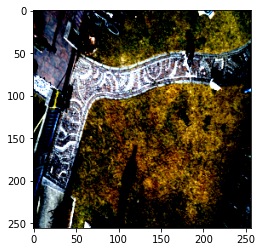

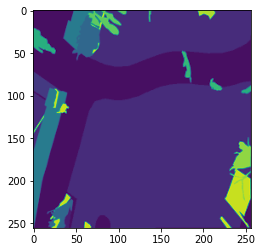

In [21]:
# permuting to change to (256,256,3)
x=x.permute((1,2,0))
plt.imshow(x)
plt.show()
plt.imshow(y)

In [12]:
# Splitting into train and val set
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [350, 50])

In [13]:
# passing into dataloader
train_dl = DataLoader(train_dataset, batch_size=12, shuffle=True)
valid_dl = DataLoader(val_dataset, batch_size=12, shuffle=True)

In [24]:
# checking the shapes for batches of images
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([12, 3, 256, 256]), torch.Size([12, 256, 256]))

## **DeepLabV3 model**

In [14]:
import torchvision.models as models

In [15]:
deeplabv3_resnet_50=models.segmentation.deeplabv3_resnet50(pretrained=False,progress=True, num_classes=NUM_OF_CLASSES)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [17]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device="cpu"
deeplabv3_resnet_50=deeplabv3_resnet_50.to(device)

In [28]:
xb=xb.to(device)
y=deeplabv3_resnet_50(xb)['out'] # returns ordereddict, so mention['out'] to get the desired output
y.shape

torch.Size([12, 26, 256, 256])

In [29]:
#loss function
loss=torch.nn.CrossEntropyLoss()

#optimizer
# NB: Hyperparameter Tune with callbacks to get better result
optimizer=torch.optim.Adam(deeplabv3_resnet_50.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.1)

In [30]:
epochs = 10
for e in range(epochs):
    running_loss = 0
    c=0
    for images, labels in train_dl:
        images,labels=images.to(device),labels.to(device)
        # Training pass
        #print(type(labels))
        optimizer.zero_grad()
        
        output = deeplabv3_resnet_50(images)["out"]
        labels=labels.long()
        lossi = loss(output, labels)
        lossi.backward()
        optimizer.step()
        print(f"batch {c}, loss-->{lossi.item()}")
        c=c+1
        running_loss += lossi.item()
    print("*"*40)
    print(f"epoch {e}, loss-->{running_loss}")
    print("*"*40)


batch 0, loss-->3.343722105026245
batch 1, loss-->2.958677053451538
batch 2, loss-->2.4603257179260254
batch 3, loss-->2.1860249042510986
batch 4, loss-->2.277951955795288
batch 5, loss-->2.0303192138671875
batch 6, loss-->1.8445998430252075
batch 7, loss-->2.0581626892089844
batch 8, loss-->1.8263602256774902
batch 9, loss-->1.8214353322982788
batch 10, loss-->1.6140904426574707
batch 11, loss-->1.6580853462219238
batch 12, loss-->1.834234595298767
batch 13, loss-->1.3936623334884644
batch 14, loss-->1.3462506532669067
batch 15, loss-->1.6973904371261597
batch 16, loss-->1.488450527191162
batch 17, loss-->1.1923798322677612
batch 18, loss-->1.2390550374984741
batch 19, loss-->1.6304866075515747
batch 20, loss-->1.414027214050293
batch 21, loss-->1.8556963205337524
batch 22, loss-->1.7521772384643555
batch 23, loss-->1.7527971267700195
batch 24, loss-->1.48225736618042
batch 25, loss-->1.7925468683242798
batch 26, loss-->1.3438881635665894
batch 27, loss-->1.508150577545166
batch 28, l

In [33]:
torch.save(deeplabv3_resnet_50.state_dict(), "/content/drive/My Drive/Deep Learning/Image Segmentation/Semantic Segmentation/deeplab_checkpoint.pth")

In [19]:
model_path="/content/drive/My Drive/Deep Learning/Image Segmentation/Semantic Segmentation/deeplab_checkpoint.pth"
model_ = models.segmentation.deeplabv3_resnet50(num_classes=NUM_OF_CLASSES).to(device)
model_.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [20]:
# trying out for 1 batch of mage
X, Y = next(iter(valid_dl))
X, Y = X.to(device), Y.to(device)
Y_pred = model_(X)['out']
print(Y_pred.shape)
# getting argmax of last layer for axis with 26 dimension
Y_pred = torch.argmax(Y_pred, dim=1)
print(Y_pred.shape)

torch.Size([12, 26, 256, 256])
torch.Size([12, 256, 256])


In [21]:
inverse_transform = transforms.Compose([
    transforms.Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), (1/0.229, 1/0.224, 1/0.225))
])

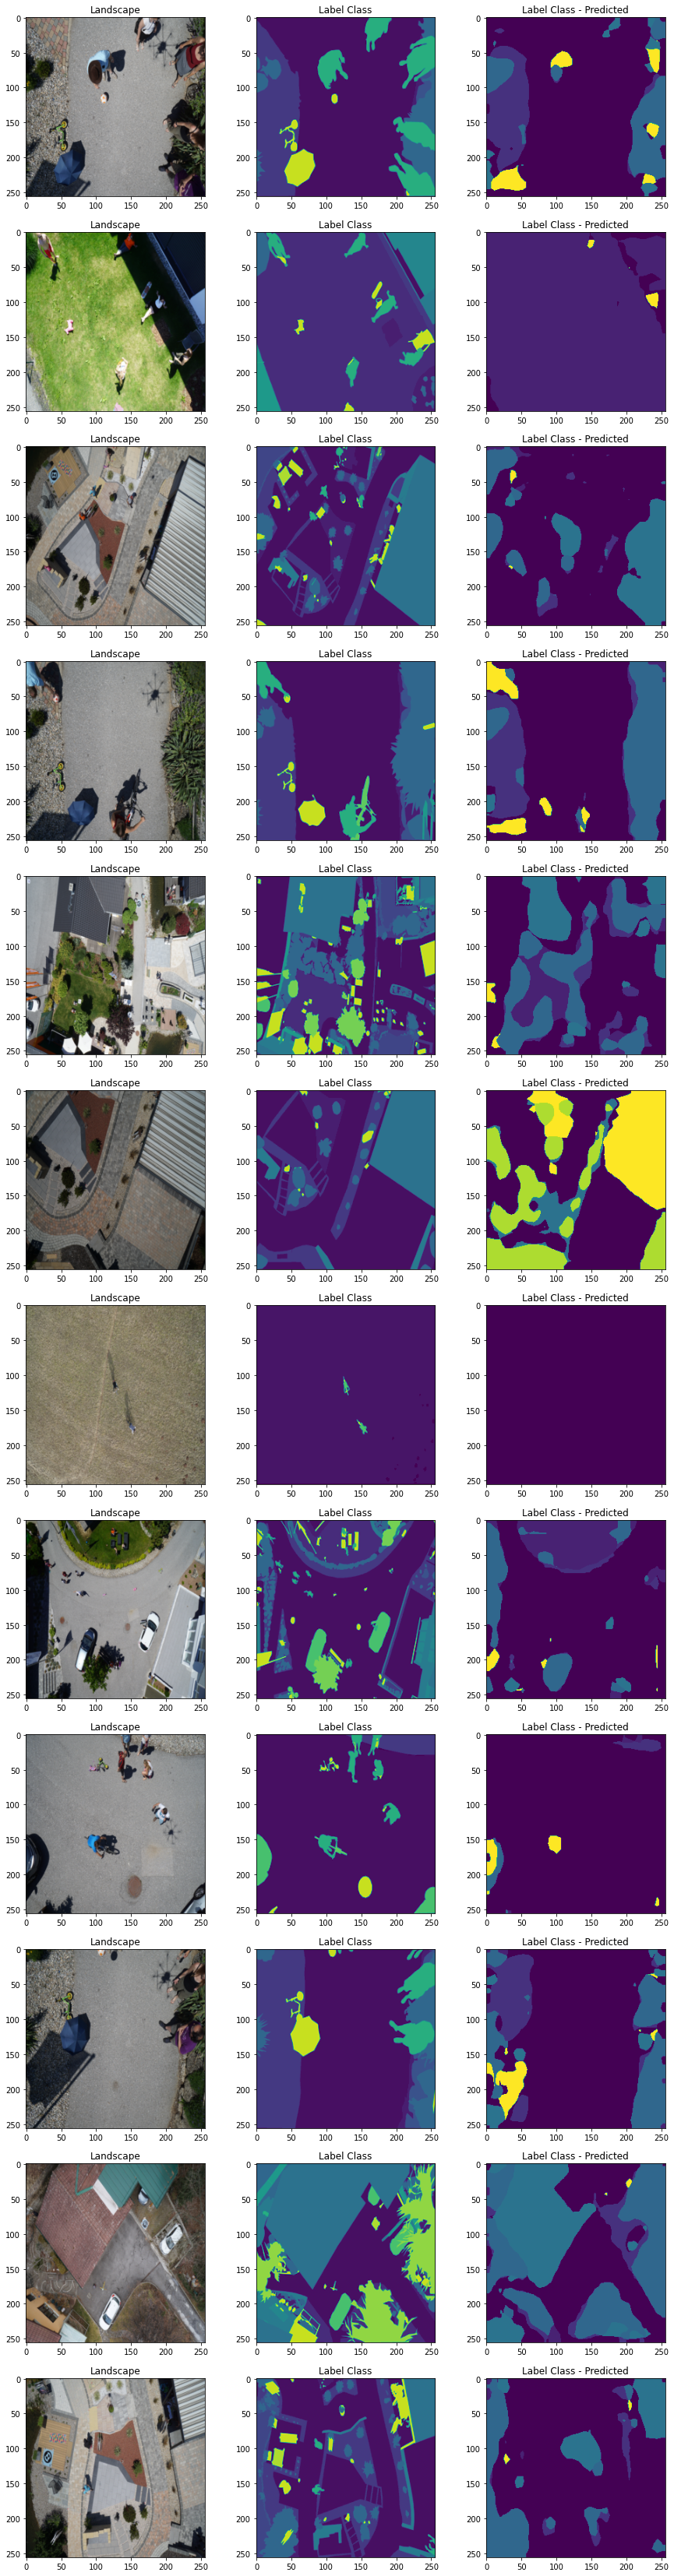

In [22]:
fig, axes = plt.subplots(12, 3, figsize=(3*5, 12*5))

for i in range(12):
    
    landscape = inverse_transform(X[i]).permute(1, 2, 0).cpu().detach().numpy()
    label_class = Y[i].cpu().detach().numpy()
    label_class_predicted = Y_pred[i].cpu().detach().numpy()
    
    axes[i, 0].imshow(landscape)
    axes[i, 0].set_title("Landscape")
    axes[i, 1].imshow(label_class)
    axes[i, 1].set_title("Label Class")
    axes[i, 2].imshow(label_class_predicted)
    axes[i, 2].set_title("Label Class - Predicted")